# Load Air Quality points

Please execute the following command to install the required packages:

```bash
pip install -r requirements.txt 
```

before running the notebook

In [121]:
import pathlib


air_quality_dir = pathlib.Path("air-data")

points = []
for file in air_quality_dir.iterdir():    
    with open(file, "r") as f:
        points.extend(f.readlines())

In [122]:
import json

air_quality_points = [json.loads(point.strip()) for point in points]

In [123]:
len(air_quality_points)

93600

In [124]:
data = []

for aq_point in air_quality_points:
    for pollutant in aq_point.get("pollutants", []):
        aq_data = {"datetime": aq_point.get("dateTime")}

        pollutant_code = pollutant.get("code")
        aq_data["pollutant_code"] = pollutant_code
        aq_data["value"] = pollutant.get("concentration", {}).get("value")
        aq_data["units"] = pollutant.get("concentration", {}).get("units")
    
        aq_data["latitude"] = aq_point.get("latitude")
        aq_data["longitude"] = aq_point.get("longitude")
        aq_data["point_name"] = aq_point.get("point")
        
        data.append(aq_data)

In [125]:
import pandas as pd

df = pd.DataFrame(data)

## Sample of air quality data

In [126]:
df.sample(5)

,datetime,pollutant_code,value,units,latitude,longitude,point_name
173485,2025-08-15T19:00:00Z,no2,0.79,PARTS_PER_BILLION,-16.445288,-71.562713,jacobohunter_arequipa_peru_1
97698,2025-08-11T02:00:00Z,co,448.76,PARTS_PER_BILLION,-16.463468,-71.598993,tiabaya_arequipa_peru_0
236394,2025-08-21T10:00:00Z,co,223.86,PARTS_PER_BILLION,-16.449978,-71.598993,tiabaya_arequipa_peru_1
525908,2025-08-16T22:00:00Z,o3,37.99,PARTS_PER_BILLION,-16.641987,-71.371502,polobaya_arequipa_peru_4
111976,2025-08-30T11:00:00Z,pm25,13.88,MICROGRAMS_PER_CUBIC_METER,-16.588392,-71.795725,lajoya_arequipa_peru_0


## Removing numbers for creating district name

In [127]:
df["district_name"] = df["point_name"].str[:-2]

## Average the pollulant value grouping by district, pollulant code and datetime. That will returns a representative value per pollulant

In [128]:
df_average = df.groupby(['district_name', 'pollutant_code', 'datetime']).agg({
    'value': 'mean',
    'units': 'first',
    'latitude': 'first',
    'longitude': 'first',
}).reset_index()

In [129]:
df_average.head()

,district_name,pollutant_code,datetime,value,units,latitude,longitude
0,altoselvaalegre_arequipa_peru,co,2025-08-11T02:00:00Z,376.674,PARTS_PER_BILLION,-16.317569,-71.48553
1,altoselvaalegre_arequipa_peru,co,2025-08-11T03:00:00Z,432.960,PARTS_PER_BILLION,-16.317569,-71.48553
2,altoselvaalegre_arequipa_peru,co,2025-08-11T04:00:00Z,407.316,PARTS_PER_BILLION,-16.317569,-71.48553
3,altoselvaalegre_arequipa_peru,co,2025-08-11T05:00:00Z,381.666,PARTS_PER_BILLION,-16.317569,-71.48553
4,altoselvaalegre_arequipa_peru,co,2025-08-11T06:00:00Z,356.106,PARTS_PER_BILLION,-16.317569,-71.48553


## Cast the datetime object to datetime type

In [130]:
df_average["datetime"] = pd.to_datetime(df_average["datetime"])

## Define the morning, evening and night hours for adding 'day_period'

In [131]:
from datetime import datetime, timedelta

def day_period(dt: datetime):
    dt_peru = dt - timedelta(hours=5)
    
    if dt_peru.hour > 6 and dt_peru.hour < 10:
        return 'morning'
    elif dt_peru.hour > 12 and dt_peru.hour < 16:
        return 'evening'
    elif dt_peru.hour > 18 and dt_peru.hour < 22:
        return 'night'
    else:
        return 'normal'

df_average['day_period'] = df_average['datetime'].apply(day_period)

In [132]:
df_average.sample(5)

,district_name,pollutant_code,datetime,value,units,latitude,longitude,day_period
114476,yanahuara_arequipa_peru,so2,2025-08-31 22:00:00+00:00,0.950,PARTS_PER_BILLION,-16.394789,-71.550419,normal
63146,polobaya_arequipa_peru,so2,2025-08-16 16:00:00+00:00,0.708,PARTS_PER_BILLION,-16.628497,-71.357423,normal
74284,sachaca_arequipa_peru,o3,2025-09-07 18:00:00+00:00,61.400,PARTS_PER_BILLION,-16.421063,-71.562182,evening
113412,yanahuara_arequipa_peru,pm25,2025-08-16 14:00:00+00:00,22.420,MICROGRAMS_PER_CUBIC_METER,-16.394789,-71.550419,morning
7620,arequipa_arequipa_peru,pm25,2025-09-03 02:00:00+00:00,33.990,MICROGRAMS_PER_CUBIC_METER,-16.406798,-71.524124,night


## Select max pollulant value grouping by district, pollulant code and day period

In [133]:
df_max = df_average.groupby(['district_name', 'pollutant_code', 'day_period']).agg({
    'value': 'max',
    'latitude': 'first',
    'longitude': 'first',
    'units': 'first',
}).reset_index()

## Normalize district name

In [134]:
df_max["district_name"] = df_max["district_name"].str.replace("á", "a").str.replace("é", "e").str.replace("í", "i").str.replace("ó", "o").str.replace("ú", "u")

In [135]:
df_max.sample(5)

,district_name,pollutant_code,day_period,value,latitude,longitude,units
609,vitor_arequipa_peru,o3,morning,43.150,-16.489369,-71.987767,PARTS_PER_BILLION
685,yura_arequipa_peru,pm10,morning,191.812,-16.130952,-71.620385,MICROGRAMS_PER_CUBIC_METER
288,paucarpata_arequipa_peru,co,evening,135.288,-16.406629,-71.477928,PARTS_PER_BILLION
525,santaritadesiguas_arequipa_peru,so2,morning,1.010,-16.522921,-72.158182,PARTS_PER_BILLION
518,santaritadesiguas_arequipa_peru,pm10,night,33.772,-16.522921,-72.158182,MICROGRAMS_PER_CUBIC_METER


## Filter by NO2 pollulant for incoming analysis

In [136]:
df_no2 = df_max[df_max['pollutant_code'] == 'no2']

In [137]:
top_no2 = df_no2[(df_no2["day_period"] == "morning") | (df_no2["day_period"] == "evening") | (df_no2["day_period"] == "night")].sort_values(by="value", ascending=False).head(10)
top_no2

,district_name,pollutant_code,day_period,value,latitude,longitude,units
630,yanahuara_arequipa_peru,no2,night,46.130000,-16.394789,-71.550419,PARTS_PER_BILLION
30,arequipa_arequipa_peru,no2,night,43.696667,-16.406798,-71.524124,PARTS_PER_BILLION
174,joseluisbustamanteyrivero_arequipa_peru,no2,night,42.325000,-16.431730,-71.523013,PARTS_PER_BILLION
414,sachaca_arequipa_peru,no2,night,38.588000,-16.421063,-71.562182,PARTS_PER_BILLION
150,jacobohunter_arequipa_peru,no2,night,33.147500,-16.458778,-71.562713,PARTS_PER_BILLION
294,paucarpata_arequipa_peru,no2,night,32.312000,-16.406629,-71.477928,PARTS_PER_BILLION
582,uchumayo_arequipa_peru,no2,night,28.178000,-16.447458,-71.690557,PARTS_PER_BILLION
534,socabaya_arequipa_peru,no2,night,26.868000,-16.473318,-71.534704,PARTS_PER_BILLION
558,tiabaya_arequipa_peru,no2,night,25.942500,-16.463468,-71.598993,PARTS_PER_BILLION
78,cerrocolorado_arequipa_peru,no2,night,24.218000,-16.304421,-71.576587,PARTS_PER_BILLION


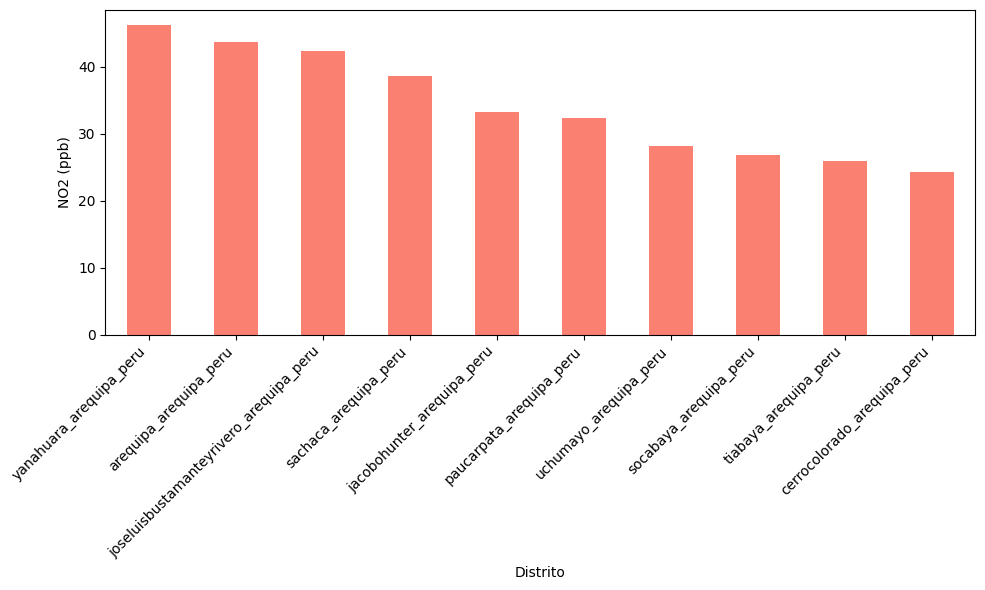

In [138]:
top_no2.plot(
    kind='bar',
    x='district_name',
    y='value',
    legend=False,
    figsize=(10, 6),
    color='salmon'
)

plt.xlabel('Distrito')
plt.ylabel('NO2 (ppb)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Create dfs per day period

In [139]:
df_no2_morning = df_no2[df_no2['day_period'] == 'morning']
df_no2_evening = df_no2[df_no2['day_period'] == 'evening']
df_no2_night = df_no2[df_no2['day_period'] == 'night']

## Define min max scale function

In [140]:
def min_max_scale(df: pd.DataFrame, key: str):
    df[f'scaled_{key}'] = df[key].apply(lambda x: (x - df[key].min()) / (df[key].max() - df[key].min()))
    return df



## Scaling three dataframes for obtaining traffic index (scaled_value)

In [141]:
min_max_scale(df_no2_morning, key="value")
min_max_scale(df_no2_evening, key="value")
min_max_scale(df_no2_night, key="value")

/var/folders/6t/6slxbt8n79v5d7g1k7qzcc280000gr/T/ipykernel_15217/884738505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'scaled_{key}'] = df[key].apply(lambda x: (x - df[key].min()) / (df[key].max() - df[key].min()))
/var/folders/6t/6slxbt8n79v5d7g1k7qzcc280000gr/T/ipykernel_15217/884738505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'scaled_{key}'] = df[key].apply(lambda x: (x - df[key].min()) / (df[key].max() - df[key].min()))
/var/folders/6t/6slxbt8n79v5d7g1k7qzcc280000gr/T/ipykern

,district_name,pollutant_code,day_period,value,latitude,longitude,units,scaled_value
6,altoselvaalegre_arequipa_peru,no2,night,21.430000,-16.317569,-71.485530,PARTS_PER_BILLION,0.434964
30,arequipa_arequipa_peru,no2,night,43.696667,-16.406798,-71.524124,PARTS_PER_BILLION,0.944335
54,cayma_arequipa_peru,no2,night,15.746000,-16.239419,-71.457130,PARTS_PER_BILLION,0.304937
78,cerrocolorado_arequipa_peru,no2,night,24.218000,-16.304421,-71.576587,PARTS_PER_BILLION,0.498742
102,characato_arequipa_peru,no2,night,12.850000,-16.457743,-71.382868,PARTS_PER_BILLION,0.238688
126,chiguata_arequipa_peru,no2,night,12.866000,-16.362086,-71.358645,PARTS_PER_BILLION,0.239054
150,jacobohunter_arequipa_peru,no2,night,33.147500,-16.458778,-71.562713,PARTS_PER_BILLION,0.703013
174,joseluisbustamanteyrivero_arequipa_peru,no2,night,42.325000,-16.431730,-71.523013,PARTS_PER_BILLION,0.912957
198,lajoya_arequipa_peru,no2,night,11.048000,-16.588391,-71.809800,PARTS_PER_BILLION,0.197465
222,marianomelgar_arequipa_peru,no2,night,20.540000,-16.361976,-71.462944,PARTS_PER_BILLION,0.414604


# Denuncias policiales

The data was downloaded from the below link

https://www.datosabiertos.gob.pe/dataset/denuncias-policiales-1

In [142]:
df_denuncias = pd.read_csv('denuncias.csv')

In [143]:
df_denuncias.sample(10)

,ANIO,MES,DPTO_HECHO_NEW,PROV_HECHO,DIST_HECHO,UBIGEO_HECHO,P_MODALIDADES,cantidad
95697,2020,9,ANCASH,HUAYLAS,HUAYLAS,21204,Violencia contra la mujer e integrantes,1
278804,2024,8,CAJAMARCA,CHOTA,CHOTA,60401,Violencia contra la mujer e integrantes,34
916,2018,1,HUANUCO,HUANUCO,QUISQUI,100106,Violencia contra la mujer e integrantes,1
210767,2023,3,LIMA METROPOLITANA,LIMA,INDEPENDENCIA,150112,Homicidio,2
66987,2019,11,PUNO,SAN ROMAN,CABANA,211102,Otros,7
42623,2019,4,AREQUIPA,CARAVELI,ATICO,40303,Hurto,5
8587,2018,4,ICA,CHINCHA,EL CARMEN,110205,Robo,1
198006,2022,12,HUANUCO,PACHITEA,MOLINO,100803,Otros,2
223414,2023,6,PIURA,PIURA,CASTILLA,200104,Robo,96
51633,2019,7,ANCASH,YUNGAY,RANRAHIRCA,22006,Hurto,4


In [144]:
df_denuncias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324993 entries, 0 to 324992
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ANIO            324993 non-null  int64 
 1   MES             324993 non-null  int64 
 2   DPTO_HECHO_NEW  324993 non-null  object
 3   PROV_HECHO      324993 non-null  object
 4   DIST_HECHO      324993 non-null  object
 5   UBIGEO_HECHO    324993 non-null  int64 
 6   P_MODALIDADES   324993 non-null  object
 7   cantidad        324993 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.8+ MB


## Focus analysis in 2025 and Arequipa Department

In [145]:
df_aqp_last_year = df_denuncias[(df_denuncias['ANIO'] == 2025) & (df_denuncias['DPTO_HECHO_NEW'] == 'AREQUIPA')]

In [146]:
df_aqp_last_year.head()

,ANIO,MES,DPTO_HECHO_NEW,PROV_HECHO,DIST_HECHO,UBIGEO_HECHO,P_MODALIDADES,cantidad
298676,2025,1,AREQUIPA,AREQUIPA,ALTO SELVA ALEGRE,40102,Estafa,12
298677,2025,1,AREQUIPA,AREQUIPA,ALTO SELVA ALEGRE,40102,Extorsión,2
298678,2025,1,AREQUIPA,AREQUIPA,ALTO SELVA ALEGRE,40102,Homicidio,1
298679,2025,1,AREQUIPA,AREQUIPA,ALTO SELVA ALEGRE,40102,Hurto,40
298680,2025,1,AREQUIPA,AREQUIPA,ALTO SELVA ALEGRE,40102,Otros,78


In [147]:
df_aqp_last_year['DIST_HECHO'].unique().tolist()

['ALTO SELVA ALEGRE',
 'AREQUIPA',
 'CAYMA',
 'CERRO COLORADO',
 'CHARACATO',
 'CHIGUATA',
 'JACOBO HUNTER',
 'JOSE LUIS BUSTAMANTE Y RIVERO',
 'LA JOYA',
 'MARIANO MELGAR',
 'MIRAFLORES',
 'MOLLEBAYA',
 'PAUCARPATA',
 'POCSI',
 'POLOBAYA',
 'QUEQUEÑA',
 'SABANDIA',
 'SACHACA',
 'SAN JUAN DE SIGUAS',
 'SANTA RITA DE SIGUAS',
 'SOCABAYA',
 'TIABAYA',
 'UCHUMAYO',
 'VITOR',
 'YANAHUARA',
 'YARABAMBA',
 'YURA',
 'CAMANA',
 'JOSE MARIA QUIMPER',
 'MARIANO NICOLAS VALCARCEL',
 'MARISCAL CACERES',
 'NICOLAS DE PIEROLA',
 'OCOÑA',
 'QUILCA',
 'SAMUEL PASTOR',
 'ACARI',
 'ATICO',
 'BELLA UNION',
 'CARAVELI',
 'CHALA',
 'CHAPARRA',
 'HUANUHUANU',
 'JAQUI',
 'LOMAS',
 'QUICACHA',
 'YAUCA',
 'ANDAGUA',
 'APLAO',
 'AYO',
 'CHACHAS',
 'CHILCAYMARCA',
 'CHOCO',
 'HUANCARQUI',
 'MACHAGUAY',
 'ORCOPAMPA',
 'PAMPACOLCA',
 'TIPAN',
 'URACA',
 'VIRACO',
 'CABANACONDE',
 'CALLALLI',
 'CAYLLOMA',
 'CHIVAY',
 'HUAMBO',
 'HUANCA',
 'ICHUPAMPA',
 'LARI',
 'MACA',
 'MADRIGAL',
 'MAJES',
 'SAN ANTONIO DE CHUCA'

## Show crime types

In [148]:
df_aqp_last_year['P_MODALIDADES'].unique()

array(['Estafa', 'Extorsión', 'Homicidio', 'Hurto', 'Otros', 'Robo',
       'Violencia contra la mujer e integrantes'], dtype=object)

## Filter by common crimes: "Homicidio, Hurto, Robo" 

In [149]:
df_aqp_last_year_common = df_aqp_last_year[df_aqp_last_year['P_MODALIDADES'].isin(['Homicidio', 'Hurto', 'Robo'])]

## Normalize district name

In [150]:
df_aqp_last_year_common['district_name'] =  df_aqp_last_year_common['DIST_HECHO'].str.replace(' ', '').str.lower() + '_arequipa_peru'

/var/folders/6t/6slxbt8n79v5d7g1k7qzcc280000gr/T/ipykernel_15217/1640064841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aqp_last_year_common['district_name'] =  df_aqp_last_year_common['DIST_HECHO'].str.replace(' ', '').str.lower() + '_arequipa_peru'


In [151]:
df_aqp_last_year_common

,ANIO,MES,DPTO_HECHO_NEW,PROV_HECHO,DIST_HECHO,UBIGEO_HECHO,P_MODALIDADES,cantidad,district_name
298678,2025,1,AREQUIPA,AREQUIPA,ALTO SELVA ALEGRE,40102,Homicidio,1,altoselvaalegre_arequipa_peru
298679,2025,1,AREQUIPA,AREQUIPA,ALTO SELVA ALEGRE,40102,Hurto,40,altoselvaalegre_arequipa_peru
298681,2025,1,AREQUIPA,AREQUIPA,ALTO SELVA ALEGRE,40102,Robo,7,altoselvaalegre_arequipa_peru
298685,2025,1,AREQUIPA,AREQUIPA,AREQUIPA,40101,Homicidio,1,arequipa_arequipa_peru
298686,2025,1,AREQUIPA,AREQUIPA,AREQUIPA,40101,Hurto,86,arequipa_arequipa_peru
...,...,...,...,...,...,...,...,...,...
322078,2025,7,AREQUIPA,ISLAY,MEJIA,40705,Hurto,1,mejia_arequipa_peru
322082,2025,7,AREQUIPA,ISLAY,MOLLENDO,40701,Hurto,3,mollendo_arequipa_peru
322084,2025,7,AREQUIPA,ISLAY,MOLLENDO,40701,Robo,1,mollendo_arequipa_peru
322086,2025,7,AREQUIPA,ISLAY,PUNTA DE BOMBON,40706,Hurto,1,puntadebombon_arequipa_peru


## Sum number of crimes per district

In [152]:
df_aqp = df_aqp_last_year_common.groupby(['district_name']).agg({
    'cantidad': 'sum',
}).reset_index()

In [153]:
top_crimes = df_aqp.sort_values(by="cantidad", ascending=False).head(10)
top_crimes

,district_name,cantidad
5,arequipa_arequipa_peru,1125
15,cerrocolorado_arequipa_peru,960
51,paucarpata_arequipa_peru,664
35,joseluisbustamanteyrivero_arequipa_peru,441
14,cayma_arequipa_peru,394
44,miraflores_arequipa_peru,328
40,marianomelgar_arequipa_peru,317
69,socabaya_arequipa_peru,313
3,altoselvaalegre_arequipa_peru,309
76,yanahuara_arequipa_peru,282


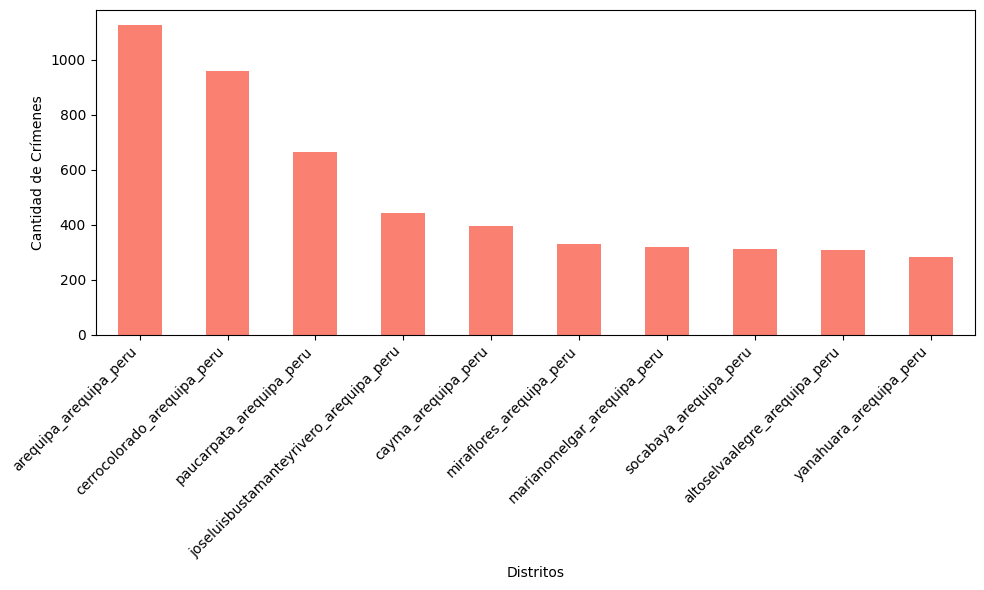

In [154]:
top_crimes.plot(
    kind='bar',
    x='district_name',
    y='cantidad',
    legend=False,
    figsize=(10, 6),
    color='salmon'
)

plt.xlabel('Distritos')
plt.ylabel('Cantidad de Crímenes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Scaled to obtain criminality index (scaled cantidad)

In [155]:
min_max_scale(df_aqp, key='cantidad')

,district_name,cantidad,scaled_cantidad
0,acari_arequipa_peru,9,0.007117
1,achoma_arequipa_peru,3,0.001779
2,alca_arequipa_peru,4,0.002669
3,altoselvaalegre_arequipa_peru,309,0.274021
4,aplao_arequipa_peru,15,0.012456
...,...,...,...
77,yanaquihua_arequipa_peru,4,0.002669
78,yanque_arequipa_peru,5,0.003559
79,yarabamba_arequipa_peru,17,0.014235
80,yauca_arequipa_peru,13,0.010676


## Show district names for dataframes to validate the merging by district name

In [156]:
df_aqp['district_name'].unique().tolist()

['acari_arequipa_peru',
 'achoma_arequipa_peru',
 'alca_arequipa_peru',
 'altoselvaalegre_arequipa_peru',
 'aplao_arequipa_peru',
 'arequipa_arequipa_peru',
 'atico_arequipa_peru',
 'bellaunion_arequipa_peru',
 'cabanaconde_arequipa_peru',
 'callalli_arequipa_peru',
 'camana_arequipa_peru',
 'caraveli_arequipa_peru',
 'cayarani_arequipa_peru',
 'caylloma_arequipa_peru',
 'cayma_arequipa_peru',
 'cerrocolorado_arequipa_peru',
 'chala_arequipa_peru',
 'chaparra_arequipa_peru',
 'characato_arequipa_peru',
 'charcana_arequipa_peru',
 'chichas_arequipa_peru',
 'chiguata_arequipa_peru',
 'chivay_arequipa_peru',
 'chuquibamba_arequipa_peru',
 'cocachacra_arequipa_peru',
 'coporaque_arequipa_peru',
 'cotahuasi_arequipa_peru',
 'deanvaldivia_arequipa_peru',
 'huambo_arequipa_peru',
 'huanca_arequipa_peru',
 'huancarqui_arequipa_peru',
 'huanuhuanu_arequipa_peru',
 'islay_arequipa_peru',
 'jacobohunter_arequipa_peru',
 'jaqui_arequipa_peru',
 'joseluisbustamanteyrivero_arequipa_peru',
 'josemari

In [157]:
df_no2_evening['district_name'].unique().tolist()

['altoselvaalegre_arequipa_peru',
 'arequipa_arequipa_peru',
 'cayma_arequipa_peru',
 'cerrocolorado_arequipa_peru',
 'characato_arequipa_peru',
 'chiguata_arequipa_peru',
 'jacobohunter_arequipa_peru',
 'joseluisbustamanteyrivero_arequipa_peru',
 'lajoya_arequipa_peru',
 'marianomelgar_arequipa_peru',
 'miraflores_arequipa_peru',
 'mollebaya_arequipa_peru',
 'paucarpata_arequipa_peru',
 'pocsi_arequipa_peru',
 'polobaya_arequipa_peru',
 'quequeña_arequipa_peru',
 'sabandia_arequipa_peru',
 'sachaca_arequipa_peru',
 'sanjuandesiguas_arequipa_peru',
 'sanjuandetarucani_arequipa_peru',
 'santaisabeldesiguas_arequipa_peru',
 'santaritadesiguas_arequipa_peru',
 'socabaya_arequipa_peru',
 'tiabaya_arequipa_peru',
 'uchumayo_arequipa_peru',
 'vitor_arequipa_peru',
 'yanahuara_arequipa_peru',
 'yarabamba_arequipa_peru',
 'yura_arequipa_peru']

## Merge dataframes and adding criminality index if found

In [158]:
df_no2_morning_aqp = pd.merge(
    df_no2_morning,
    df_aqp,
    how="left",
    on='district_name'
)

df_no2_evening_aqp = pd.merge(
    df_no2_evening,
    df_aqp,
    how="left",
    on='district_name'
)

df_no2_night_aqp = pd.merge(
    df_no2_night,
    df_aqp,
    how="left",
    on='district_name'
)

## Show evening evening data after merging

In [159]:
df_no2_evening_aqp

,district_name,pollutant_code,day_period,value,latitude,longitude,units,scaled_value,cantidad,scaled_cantidad
0,altoselvaalegre_arequipa_peru,no2,evening,1.000,-16.317569,-71.485530,PARTS_PER_BILLION,0.055506,309,0.274021
1,arequipa_arequipa_peru,no2,evening,10.980,-16.406798,-71.524124,PARTS_PER_BILLION,0.790194,1125,1.000000
2,cayma_arequipa_peru,no2,evening,0.856,-16.239419,-71.457130,PARTS_PER_BILLION,0.044906,394,0.349644
3,cerrocolorado_arequipa_peru,no2,evening,1.120,-16.304421,-71.576587,PARTS_PER_BILLION,0.064340,960,0.853203
4,characato_arequipa_peru,no2,evening,0.686,-16.457743,-71.382868,PARTS_PER_BILLION,0.032391,54,0.047153
5,chiguata_arequipa_peru,no2,evening,1.632,-16.362086,-71.358645,PARTS_PER_BILLION,0.102032,22,0.018683
6,jacobohunter_arequipa_peru,no2,evening,4.495,-16.458778,-71.562713,PARTS_PER_BILLION,0.312794,139,0.122776
7,joseluisbustamanteyrivero_arequipa_peru,no2,evening,8.765,-16.431730,-71.523013,PARTS_PER_BILLION,0.627135,441,0.391459
8,lajoya_arequipa_peru,no2,evening,0.498,-16.588391,-71.809800,PARTS_PER_BILLION,0.018551,142,0.125445
9,marianomelgar_arequipa_peru,no2,evening,0.950,-16.361976,-71.462944,PARTS_PER_BILLION,0.051826,317,0.281139


## Calculating urban risk index based on traffic index(scaled_value) and criminality index(scaled_cantidad)

In [160]:
df_no2_morning_aqp["urban_risk_index"] = df_no2_morning_aqp["scaled_value"]*0.5 + df_no2_morning_aqp["scaled_cantidad"]*0.5
df_no2_evening_aqp["urban_risk_index"] = df_no2_evening_aqp["scaled_value"]*0.5 + df_no2_evening_aqp["scaled_cantidad"]*0.5
df_no2_night_aqp["urban_risk_index"] = df_no2_night_aqp["scaled_value"]*0.5 + df_no2_night_aqp["scaled_cantidad"]*0.5

In [161]:
df_no2_morning_aqp.sort_values(by="urban_risk_index", ascending=False)

,district_name,pollutant_code,day_period,value,latitude,longitude,units,scaled_value,cantidad,scaled_cantidad,urban_risk_index
1,arequipa_arequipa_peru,no2,morning,20.5900,-16.406798,-71.524124,PARTS_PER_BILLION,0.894908,1125,1.000000,0.947454
26,yanahuara_arequipa_peru,no2,morning,22.4600,-16.394789,-71.550419,PARTS_PER_BILLION,1.000000,282,0.250000,0.625000
3,cerrocolorado_arequipa_peru,no2,morning,11.5600,-16.304421,-71.576587,PARTS_PER_BILLION,0.387434,960,0.853203,0.620318
7,joseluisbustamanteyrivero_arequipa_peru,no2,morning,18.4100,-16.431730,-71.523013,PARTS_PER_BILLION,0.772395,441,0.391459,0.581927
12,paucarpata_arequipa_peru,no2,morning,14.4240,-16.406629,-71.477928,PARTS_PER_BILLION,0.548387,664,0.589858,0.569122
17,sachaca_arequipa_peru,no2,morning,15.9900,-16.421063,-71.562182,PARTS_PER_BILLION,0.636394,97,0.085409,0.360902
22,socabaya_arequipa_peru,no2,morning,12.0680,-16.473318,-71.534704,PARTS_PER_BILLION,0.415983,313,0.277580,0.346781
6,jacobohunter_arequipa_peru,no2,morning,14.0150,-16.458778,-71.562713,PARTS_PER_BILLION,0.525402,139,0.122776,0.324089
0,altoselvaalegre_arequipa_peru,no2,morning,10.3760,-16.317569,-71.485530,PARTS_PER_BILLION,0.320895,309,0.274021,0.297458
10,miraflores_arequipa_peru,no2,morning,9.9200,-16.356374,-71.457064,PARTS_PER_BILLION,0.295268,328,0.290925,0.293097


In [162]:
df_no2_evening_aqp.sort_values(by="urban_risk_index", ascending=False)

,district_name,pollutant_code,day_period,value,latitude,longitude,units,scaled_value,cantidad,scaled_cantidad,urban_risk_index
1,arequipa_arequipa_peru,no2,evening,10.980,-16.406798,-71.524124,PARTS_PER_BILLION,0.790194,1125,1.000000,0.895097
26,yanahuara_arequipa_peru,no2,evening,13.830,-16.394789,-71.550419,PARTS_PER_BILLION,1.000000,282,0.250000,0.625000
12,paucarpata_arequipa_peru,no2,evening,6.868,-16.406629,-71.477928,PARTS_PER_BILLION,0.487485,664,0.589858,0.538671
7,joseluisbustamanteyrivero_arequipa_peru,no2,evening,8.765,-16.431730,-71.523013,PARTS_PER_BILLION,0.627135,441,0.391459,0.509297
3,cerrocolorado_arequipa_peru,no2,evening,1.120,-16.304421,-71.576587,PARTS_PER_BILLION,0.064340,960,0.853203,0.458772
17,sachaca_arequipa_peru,no2,evening,6.446,-16.421063,-71.562182,PARTS_PER_BILLION,0.456419,97,0.085409,0.270914
22,socabaya_arequipa_peru,no2,evening,2.530,-16.473318,-71.534704,PARTS_PER_BILLION,0.168139,313,0.277580,0.222860
6,jacobohunter_arequipa_peru,no2,evening,4.495,-16.458778,-71.562713,PARTS_PER_BILLION,0.312794,139,0.122776,0.217785
2,cayma_arequipa_peru,no2,evening,0.856,-16.239419,-71.457130,PARTS_PER_BILLION,0.044906,394,0.349644,0.197275
10,miraflores_arequipa_peru,no2,evening,0.950,-16.356374,-71.457064,PARTS_PER_BILLION,0.051826,328,0.290925,0.171375


In [163]:
df_no2_night_aqp.sort_values(by="urban_risk_index", ascending=False)

,district_name,pollutant_code,day_period,value,latitude,longitude,units,scaled_value,cantidad,scaled_cantidad,urban_risk_index
1,arequipa_arequipa_peru,no2,night,43.696667,-16.406798,-71.524124,PARTS_PER_BILLION,0.944335,1125,1.000000,0.972168
3,cerrocolorado_arequipa_peru,no2,night,24.218000,-16.304421,-71.576587,PARTS_PER_BILLION,0.498742,960,0.853203,0.675972
7,joseluisbustamanteyrivero_arequipa_peru,no2,night,42.325000,-16.431730,-71.523013,PARTS_PER_BILLION,0.912957,441,0.391459,0.652208
12,paucarpata_arequipa_peru,no2,night,32.312000,-16.406629,-71.477928,PARTS_PER_BILLION,0.683900,664,0.589858,0.636879
26,yanahuara_arequipa_peru,no2,night,46.130000,-16.394789,-71.550419,PARTS_PER_BILLION,1.000000,282,0.250000,0.625000
17,sachaca_arequipa_peru,no2,night,38.588000,-16.421063,-71.562182,PARTS_PER_BILLION,0.827469,97,0.085409,0.456439
22,socabaya_arequipa_peru,no2,night,26.868000,-16.473318,-71.534704,PARTS_PER_BILLION,0.559363,313,0.277580,0.418472
6,jacobohunter_arequipa_peru,no2,night,33.147500,-16.458778,-71.562713,PARTS_PER_BILLION,0.703013,139,0.122776,0.412894
0,altoselvaalegre_arequipa_peru,no2,night,21.430000,-16.317569,-71.485530,PARTS_PER_BILLION,0.434964,309,0.274021,0.354492
10,miraflores_arequipa_peru,no2,night,20.350000,-16.356374,-71.457064,PARTS_PER_BILLION,0.410258,328,0.290925,0.350591


# Graph district heatmaps based on urban risk

In [164]:
with open("arequipa.txt", "r") as f:
    districts = f.readlines()

districts = [district.strip() for district in districts]

In [165]:
districts

['Arequipa, Arequipa, Peru',
 'Alto Selva Alegre, Arequipa, Peru',
 'Cayma, Arequipa, Peru',
 'Cerro Colorado, Arequipa, Peru',
 'Characato, Arequipa, Peru',
 'Chiguata, Arequipa, Peru',
 'Jacobo Hunter, Arequipa, Peru',
 'José Luis Bustamante y Rivero, Arequipa, Peru',
 'La Joya, Arequipa, Peru',
 'Mariano Melgar, Arequipa, Peru',
 'Miraflores, Arequipa, Peru',
 'Mollebaya, Arequipa, Peru',
 'Paucarpata, Arequipa, Peru',
 'Pocsi, Arequipa, Peru',
 'Polobaya, Arequipa, Peru',
 'Quequeña, Arequipa, Peru',
 'Sabandía, Arequipa, Peru',
 'Sachaca, Arequipa, Peru',
 'San Juan de Siguas, Arequipa, Peru',
 'San Juan de Tarucani, Arequipa, Peru',
 'Santa Isabel de Siguas, Arequipa, Peru',
 'Santa Rita de Siguas, Arequipa, Peru',
 'Socabaya, Arequipa, Peru',
 'Tiabaya, Arequipa, Peru',
 'Uchumayo, Arequipa, Peru',
 'Vítor, Arequipa, Peru',
 'Yanahuara, Arequipa, Peru',
 'Yarabamba, Arequipa, Peru',
 'Yura, Arequipa, Peru']

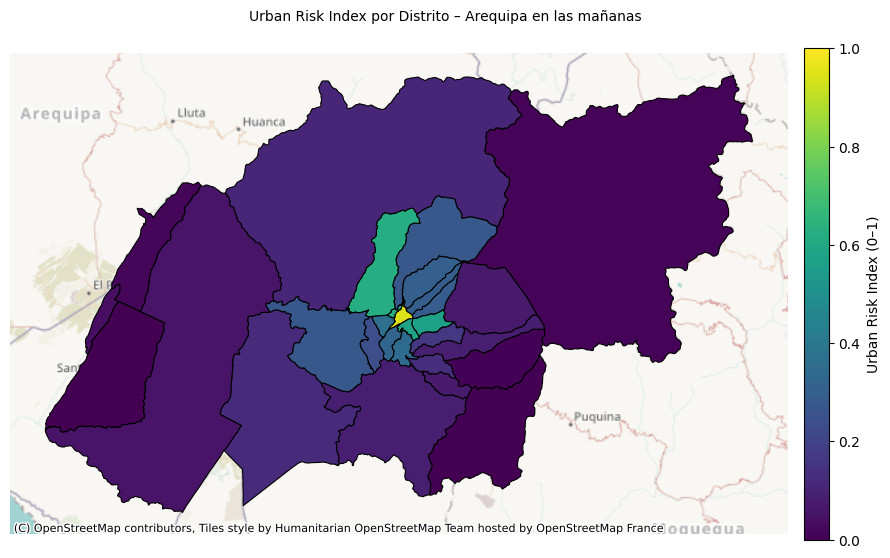

In [166]:
import re, unicodedata
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx


gdfs = []
for q in districts:
    gd = ox.geocode_to_gdf(q)[["geometry"]].copy()
    gd["distrito"] = q.split(",")[0]
    gdfs.append(gd)

gdf_distritos = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs="EPSG:4326")



def norm_key(s: str) -> str:
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.lower()
    s = re.sub(r"_arequipa_peru$", "", s)
    s = re.sub(r"[^a-z]+", "", s)
    return s

gdf_distritos["key"] = gdf_distritos["distrito"].apply(norm_key)

df_scores = (
    df_no2_morning_aqp[["district_name", "urban_risk_index"]]
    .copy()
)
df_scores["key"] = df_scores["district_name"].apply(norm_key)


gdf_distritos = gdf_distritos.merge(
    df_scores[["key", "urban_risk_index"]],
    on="key",
    how="left"
)

# Control de valores (0–1) y faltantes
gdf_distritos["urban_risk_index"] = (
    gdf_distritos["urban_risk_index"]
    .astype(float)
)


gdf_distritos_3857 = gdf_distritos.to_crs(3857)

fig, ax = plt.subplots(figsize=(9, 9))

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=1)

gdf_distritos_3857.plot(
    ax=ax,
    column="urban_risk_index",
    cmap=cmap,
    edgecolor="black",
    linewidth=0.8,
    vmin=0, vmax=1,
    missing_kwds={"color": "lightgrey", "hatch": "///", "label": "Sin dato"}
)

# Basemap
cx.add_basemap(ax, crs=gdf_distritos_3857.crs, alpha=0.85)

# Barra de color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Urban Risk Index (0–1)")

ax.set_axis_off()
plt.suptitle("Urban Risk Index por Distrito – Arequipa en las mañanas", fontsize=10, y=0.8)

plt.tight_layout()
plt.show()



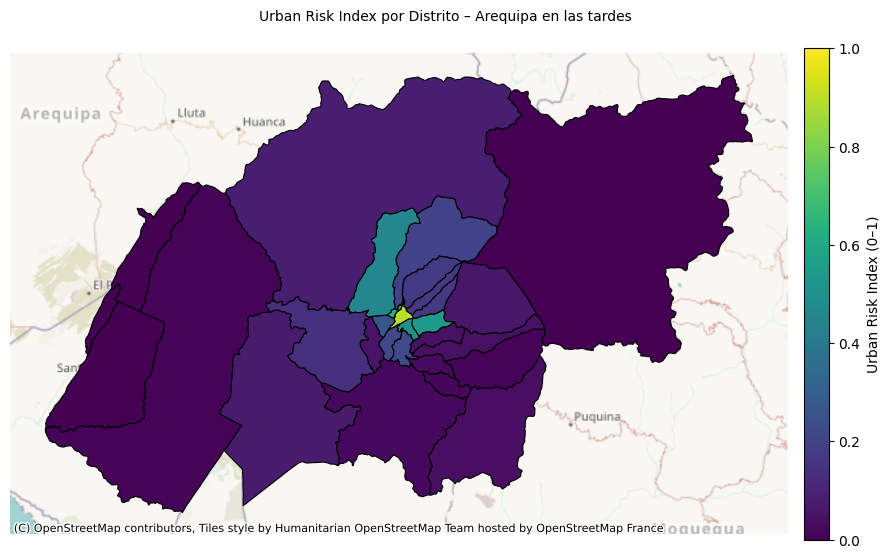

In [167]:
gdfs = []
for q in districts:
    gd = ox.geocode_to_gdf(q)[["geometry"]].copy()
    gd["distrito"] = q.split(",")[0]
    gdfs.append(gd)

gdf_distritos = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs="EPSG:4326")



def norm_key(s: str) -> str:
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.lower()
    s = re.sub(r"_arequipa_peru$", "", s)
    s = re.sub(r"[^a-z]+", "", s)
    return s

gdf_distritos["key"] = gdf_distritos["distrito"].apply(norm_key)

df_scores = (
    df_no2_evening_aqp[["district_name", "urban_risk_index"]]
    .copy()
)
df_scores["key"] = df_scores["district_name"].apply(norm_key)


gdf_distritos = gdf_distritos.merge(
    df_scores[["key", "urban_risk_index"]],
    on="key",
    how="left"
)

# Control de valores (0–1) y faltantes
gdf_distritos["urban_risk_index"] = (
    gdf_distritos["urban_risk_index"]
    .astype(float)
)


gdf_distritos_3857 = gdf_distritos.to_crs(3857)

fig, ax = plt.subplots(figsize=(9, 9))

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=1)

gdf_distritos_3857.plot(
    ax=ax,
    column="urban_risk_index",
    cmap=cmap,
    edgecolor="black",
    linewidth=0.8,
    vmin=0, vmax=1,
    missing_kwds={"color": "lightgrey", "hatch": "///", "label": "Sin dato"}
)

# Basemap
cx.add_basemap(ax, crs=gdf_distritos_3857.crs, alpha=0.85)

# Barra de color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Urban Risk Index (0–1)")

ax.set_axis_off()
plt.suptitle("Urban Risk Index por Distrito – Arequipa en las tardes", fontsize=10, y=0.8)

plt.tight_layout()
plt.show()


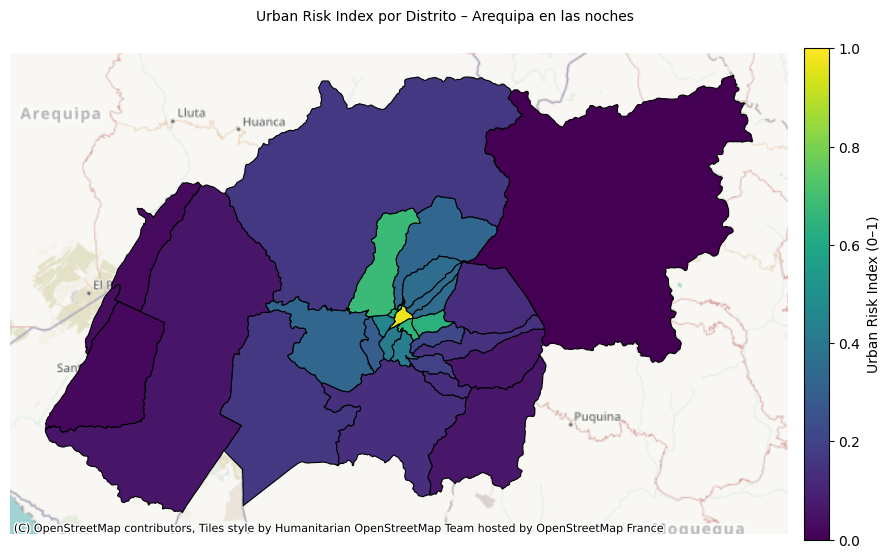

In [168]:
gdfs = []
for q in districts:
    gd = ox.geocode_to_gdf(q)[["geometry"]].copy()
    gd["distrito"] = q.split(",")[0]
    gdfs.append(gd)

gdf_distritos = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs="EPSG:4326")



def norm_key(s: str) -> str:
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("ascii")
    s = s.lower()
    s = re.sub(r"_arequipa_peru$", "", s)
    s = re.sub(r"[^a-z]+", "", s)
    return s

gdf_distritos["key"] = gdf_distritos["distrito"].apply(norm_key)

df_scores = (
    df_no2_night_aqp[["district_name", "urban_risk_index"]]
    .copy()
)
df_scores["key"] = df_scores["district_name"].apply(norm_key)


gdf_distritos = gdf_distritos.merge(
    df_scores[["key", "urban_risk_index"]],
    on="key",
    how="left"
)

# Control de valores (0–1) y faltantes
gdf_distritos["urban_risk_index"] = (
    gdf_distritos["urban_risk_index"]
    .astype(float)
)


gdf_distritos_3857 = gdf_distritos.to_crs(3857)

fig, ax = plt.subplots(figsize=(9, 9))

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0, vmax=1)

gdf_distritos_3857.plot(
    ax=ax,
    column="urban_risk_index",
    cmap=cmap,
    edgecolor="black",
    linewidth=0.8,
    vmin=0, vmax=1,
    missing_kwds={"color": "lightgrey", "hatch": "///", "label": "Sin dato"}
)

# Basemap
cx.add_basemap(ax, crs=gdf_distritos_3857.crs, alpha=0.85)

# Barra de color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Urban Risk Index (0–1)")

ax.set_axis_off()
plt.suptitle("Urban Risk Index por Distrito – Arequipa en las noches", fontsize=10, y=0.8)

plt.tight_layout()
plt.show()
